In [2]:
pip install torch torchvision matplotlib


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [3]:
pip install google-colab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to your dataset
data_dir = '/content/drive/MyDrive/VoidDetectionnF/'

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize (mean, std)
])

# Load datasets
train_dataset = datasets.ImageFolder(data_dir + 'train', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'val', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['no_void', 'void']


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class VoidDetectionModel(nn.Module):
    def __init__(self):
        super(VoidDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input: 3 channels (RGB)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # Output: 2 classes (void, no void)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = VoidDetectionModel()


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 20
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/20, Train Loss: 1.0239, Val Loss: 0.1428, Val Accuracy: 100.00%
Epoch 2/20, Train Loss: 0.0839, Val Loss: 0.6200, Val Accuracy: 69.23%
Epoch 3/20, Train Loss: 0.2998, Val Loss: 0.0358, Val Accuracy: 100.00%
Epoch 4/20, Train Loss: 0.0263, Val Loss: 0.0066, Val Accuracy: 100.00%
Epoch 5/20, Train Loss: 0.0039, Val Loss: 0.0032, Val Accuracy: 100.00%
Epoch 6/20, Train Loss: 0.0054, Val Loss: 0.0016, Val Accuracy: 100.00%
Epoch 7/20, Train Loss: 0.0008, Val Loss: 0.0007, Val Accuracy: 100.00%
Epoch 8/20, Train Loss: 0.0003, Val Loss: 0.0003, Val Accuracy: 100.00%
Epoch 9/20, Train Loss: 0.0006, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 10/20, Train Loss: 0.0001, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 11/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 12/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 13/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 14/20, Train Loss: 0.0000, Val Loss: 0.0000, Val Accura

In [9]:
torch.save(model.state_dict(), 'void_detection_model.pth')


In [10]:
model.load_state_dict(torch.load('void_detection_model.pth'))
model.eval()


<ipython-input-10-3d364e3e87c9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('void_detection_model.pth'))


VoidDetectionModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [17]:
from PIL import Image

def predict(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

# Example prediction
test_image = '/content/drive/MyDrive/VoidDetectionnF/test_image.jpg'
result = predict(test_image, model, transform, device)
print("Prediction:", result)


Prediction: void


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

# Path to your dataset
data_dir = '/content/drive/MyDrive/VoidDetectionnF/'

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),         # Convert to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize (mean, std)
])

# Load datasets
train_dataset = datasets.ImageFolder(data_dir + 'train', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'val', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


def calculate_iou(predictions, labels):
    """Calculate IoU for binary classification."""
    smooth = 1e-6  # Avoid division by zero

    # Convert predictions and labels to binary (0 or 1)
    predictions = (predictions > 0).int()  # Assuming predictions are class indices (0 or 1)
    labels = labels.int()  # Convert labels to int type if necessary

    # Now calculate intersection and union for binary values
    intersection = (predictions & labels).float().sum()
    union = (predictions | labels).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

# Define the Model
class VoidDetectionModel(nn.Module):
    def __init__(self):
        super(VoidDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


model = VoidDetectionModel()


# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Q-learning Setup
class QLearningOptimizer:
    def __init__(self, learning_rate=0.001, discount_factor=0.9):
        self.q_table = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def update_q_table(self, state, action, reward, next_state):
        old_q_value = self.q_table.get((state, action), 0)
        max_next_q = max([self.q_table.get((next_state, a), 0) for a in range(2)], default=0)
        new_q_value = old_q_value + self.learning_rate * (reward + self.discount_factor * max_next_q - old_q_value)
        self.q_table[(state, action)] = new_q_value


q_optimizer = QLearningOptimizer()


# Training and Validation Loops
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    iou_score = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate IoU
        preds = torch.argmax(outputs, dim=1)
        iou_score += calculate_iou(preds, labels)

    return running_loss / len(loader), iou_score / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    iou_score = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate IoU
            preds = torch.argmax(outputs, dim=1)
            iou_score += calculate_iou(preds, labels)

    return running_loss / len(loader), iou_score / len(loader)


# Training with Q-Learning
epochs = 10
for epoch in range(epochs):
    state = epoch  # Simplified example; use meaningful states in real scenarios
    action = 0 if optimizer.param_groups[0]['lr'] < 0.005 else 1
    train_loss, train_iou = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_iou = validate(model, val_loader, criterion, device)

    # Q-learning reward
    reward = val_iou - train_iou  # Reward based on IoU improvement
    next_state = state + 1

    # Update Q-table
    q_optimizer.update_q_table(state, action, reward, next_state)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")


Classes: ['no_void', 'void']
Epoch 1/10, Train Loss: 0.3557, Train IoU: 0.5000, Val Loss: 3.1069, Val IoU: 0.0000
Epoch 2/10, Train Loss: 1.8277, Train IoU: 0.5000, Val Loss: 0.1346, Val IoU: 1.0000
Epoch 3/10, Train Loss: 0.1575, Train IoU: 1.0000, Val Loss: 1.2101, Val IoU: 0.5556
Epoch 4/10, Train Loss: 0.6235, Train IoU: 0.7500, Val Loss: 0.2153, Val IoU: 1.0000
Epoch 5/10, Train Loss: 0.1133, Train IoU: 1.0000, Val Loss: 0.0577, Val IoU: 1.0000
Epoch 6/10, Train Loss: 0.0384, Train IoU: 1.0000, Val Loss: 0.1119, Val IoU: 1.0000
Epoch 7/10, Train Loss: 0.1309, Train IoU: 0.9000, Val Loss: 0.0469, Val IoU: 1.0000
Epoch 8/10, Train Loss: 0.0366, Train IoU: 1.0000, Val Loss: 0.0154, Val IoU: 1.0000
Epoch 9/10, Train Loss: 0.0074, Train IoU: 1.0000, Val Loss: 0.0068, Val IoU: 1.0000
Epoch 10/10, Train Loss: 0.0033, Train IoU: 1.0000, Val Loss: 0.0057, Val IoU: 1.0000


In [19]:
from PIL import Image

def predict(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return classes[predicted.item()]

# Example prediction
test_image = '/content/drive/MyDrive/VoidDetectionnF/test_image.jpg'
result = predict(test_image, model, transform, device)
print("Prediction:", result)

Prediction: void


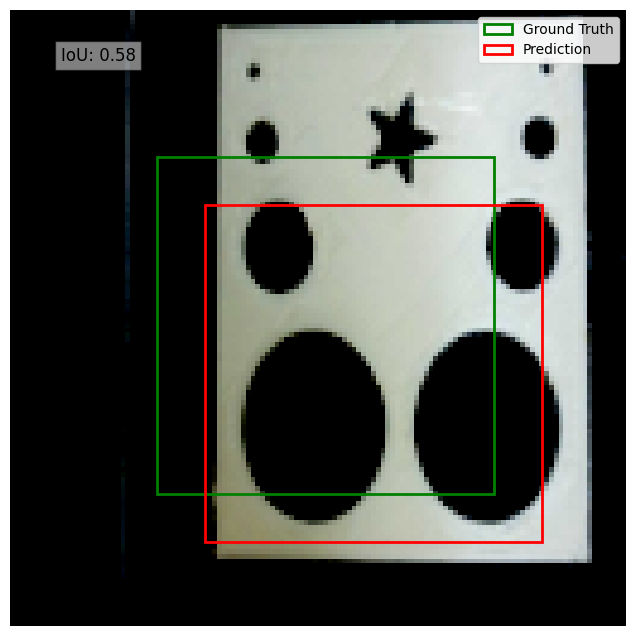

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_iou_box(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Box format: [x_min, y_min, x_max, y_max]
    """
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2

    # Calculate intersection
    xi1 = max(x1, x3)
    yi1 = max(y1, y3)
    xi2 = min(x2, x4)
    yi2 = min(y2, y4)
    intersection_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Calculate union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union_area = box1_area + box2_area - intersection_area

    # IoU calculation
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou


def visualize_boxes(image, ground_truth_box, predicted_box, iou_score):
    """
    Visualize the image with ground truth and predicted bounding boxes.
    """
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())  # Assuming image is a tensor

    # Plot Ground Truth Box
    gt_rect = patches.Rectangle(
        (ground_truth_box[0], ground_truth_box[1]),
        ground_truth_box[2] - ground_truth_box[0],
        ground_truth_box[3] - ground_truth_box[1],
        linewidth=2,
        edgecolor='green',
        facecolor='none',
        label='Ground Truth'
    )
    ax.add_patch(gt_rect)

    # Plot Predicted Box
    pred_rect = patches.Rectangle(
        (predicted_box[0], predicted_box[1]),
        predicted_box[2] - predicted_box[0],
        predicted_box[3] - predicted_box[1],
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Prediction'
    )
    ax.add_patch(pred_rect)

    # Add IoU score as text
    ax.text(
        10, 10, f"IoU: {iou_score:.2f}",
        bbox=dict(facecolor='white', alpha=0.5),
        fontsize=12,
        color='black'
    )

    ax.legend(loc="upper right")
    plt.axis("off")
    plt.show()


# Example Usage
# Assuming the image is a tensor from the DataLoader
image, label = train_dataset[15]  # Example image from the dataset
ground_truth_box = [30, 30, 100, 100]  # Replace with actual ground truth box
predicted_box = [40, 40, 110, 110]    # Replace with actual predicted box

# Calculate IoU
iou_score = calculate_iou_box(ground_truth_box, predicted_box)

# Visualize the image with bounding boxes
visualize_boxes(image, ground_truth_box, predicted_box, iou_score)
